In [1]:
#import all relevant modules . some are not necessary 
import osm2geojson
import codecs
import os
import folium
import geopandas as gpd
import earthpy as et
import osmiter
import osmnx as ox
import json
import matplotlib.pyplot as plt
import networkx as nx

C:\Users\mukes\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\mukes\AppData\Local\Temp\ipykernel_24676\190748110.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should

In [2]:
# We downloaded the raw map data from overpass turbo and checked the number of buildings
  
# Opening JSON file
f = open('export.json',encoding="utf-8")
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list
count = 0
for entry in data['elements']:
    if len(entry) == 5 and 'building' in entry['tags']:
        count += 1
#         print(entry)

print(count)


  
# Closing file
f.close()

552


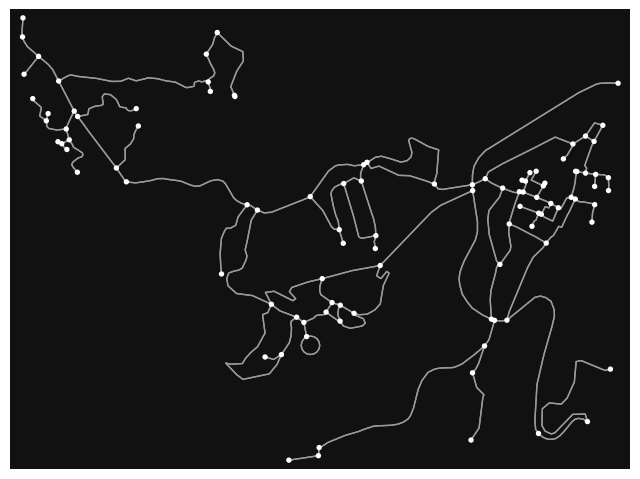

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
G = ox.graph_from_bbox(27.62164,27.61369,85.55298, 85.54105)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

In [4]:
#view the nodes of G
G.nodes

NodeView((1656490329, 1752681207, 1752681234, 1752681257, 1752681450, 1830379371, 1833813068, 2188361833, 2188361852, 2188366811, 2188366834, 2188366835, 2188366847, 2189411655, 2189411701, 2336752290, 2339332177, 2385758367, 2385758421, 2385769672, 2385799559, 2385799587, 2385801823, 2385801836, 2385801888, 2385801903, 2386738068, 2386738070, 2386740539, 2386740555, 2386740565, 2386740577, 2386740591, 2386740598, 2386745400, 2386745410, 2386745411, 2386745422, 2386745431, 2386745432, 2386745433, 2386745434, 2386745443, 2386745445, 2386748301, 2386792051, 2386792078, 2386793642, 2386797417, 2387622171, 2387622172, 2462607884, 2462607885, 2687459017, 2687459023, 2687459041, 2687459059, 2687459060, 2687459067, 2687459071, 2687459072, 2687468785, 2687468787, 3194079578, 3194079581, 3461417921, 3477225979, 3477225981, 3482777440, 3482777441, 3482777452, 3482777457, 3482777461, 3482777465, 3482824712, 3482824714, 3482832138, 3482832143, 3482832551, 3482832559, 3482832573, 3482832588, 348770

In [8]:
# Opening JSON file
f = open('export.json',encoding="utf-8")
  
# returns JSON object as 
# a dictionary
data = json.load(f)

building_data = []
  
# Iterating through the json list to get a list of all buildings
for entry in data['elements']:
    if entry['type'] == 'node' and len(entry) == 5 and 'building' in entry['tags']:
        building_data.append([entry['id'] , entry['lat'], entry['lon']])
    if entry['type'] != 'node' and len(entry) == 5 and 'building' in entry['tags']:
            building_data.append([entry['id'] , entry['center']['lat'], entry['center']['lon']])
# Closing file
f.close()
print(building_data)

[[2048141210, 27.6151897, 85.5337036], [2048141664, 27.6150115, 85.5336928], [3496259400, 27.6177791, 85.5366543], [6518254705, 27.6184124, 85.534932], [6518282587, 27.6209791, 85.5355515], [6518718188, 27.6174557, 85.5357944], [9372258798, 27.6203412, 85.5418846], [9527820253, 27.6210409, 85.5416], [9527820254, 27.6200291, 85.541262], [9527820259, 27.6203541, 85.5420654], [172099678, 27.6195396, 85.5414653], [172106984, 27.6188957, 85.538043], [172107221, 27.6193415, 85.538011], [172107400, 27.6178088, 85.5363248], [172476042, 27.6180025, 85.5378264], [172476067, 27.6201518, 85.5412166], [172476341, 27.6198457, 85.5414291], [194899356, 27.61956, 85.5385859], [194899357, 27.6189654, 85.5385725], [194900833, 27.6193203, 85.5394942], [194900835, 27.6194161, 85.5389295], [194900836, 27.6197193, 85.5393515], [194900838, 27.6189208, 85.5393304], [194902255, 27.6183671, 85.539541], [194902256, 27.6181478, 85.5396035], [194902257, 27.6186247, 85.5396755], [206049819, 27.6177151, 85.5380826], 

In [9]:
#we iterate through all permutations of the nodes and if their distance is less than a certain value 
#(which specifies the max diameter of the cluster as any cluster larger than that cannot practivally  be assigned to one person)
#here set to arbiatrily as 50

#we set the weight of he edges as the 'distance to walk' using the pathways from osm map

import itertools
WG = nx.Graph()

node_comb = itertools.permutations(building_data[:50],2)
for pair in node_comb:
    orig = ox.nearest_nodes(G,pair[0][2],pair[0][1])

    dest = ox.nearest_nodes(G,pair[1][2],pair[0][1])
    length = nx.shortest_path_length(G, orig, dest, weight='length')
    if length < 50:
        WG.add_edge(pair[0][0],pair[1][0],distance=length)

In [10]:
print(WG)

Graph with 50 nodes and 740 edges


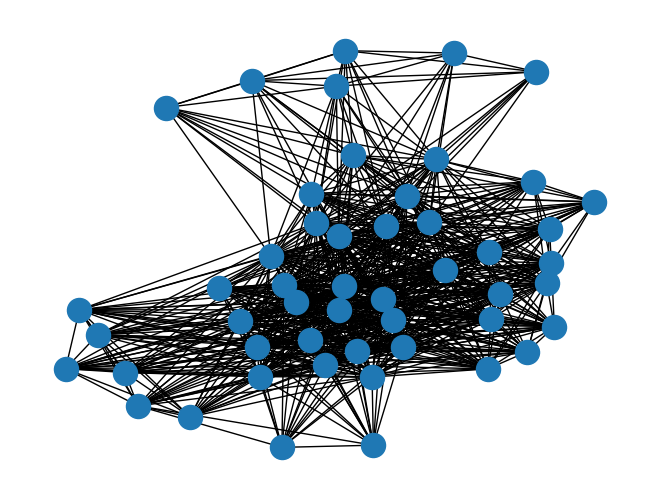

In [11]:
nx.draw_spring(WG)

In [12]:
import community
partition = community.best_partition(WG)
print(partition)

{2048141210: 0, 2048141664: 0, 6518254705: 0, 3496259400: 0, 6518282587: 0, 6518718188: 0, 172107400: 0, 9527820254: 1, 172106984: 0, 172107221: 0, 172476042: 0, 172476067: 1, 194899356: 0, 194899357: 0, 194900833: 1, 194900835: 1, 194900836: 0, 194900838: 0, 194902255: 1, 194902256: 1, 194902257: 1, 206049819: 0, 206049826: 1, 206049829: 0, 206055846: 1, 206055847: 0, 206055848: 0, 206055854: 1, 206055855: 1, 206055860: 1, 206055862: 1, 206055865: 1, 206055867: 1, 206055868: 1, 206055872: 0, 206055884: 1, 206055885: 1, 206055887: 1, 206055889: 0, 206055891: 0, 206055893: 1, 206055902: 0, 206055903: 1, 206055904: 1, 206055911: 1, 9372258798: 1, 9527820253: 1, 9527820259: 1, 172099678: 1, 172476341: 1}


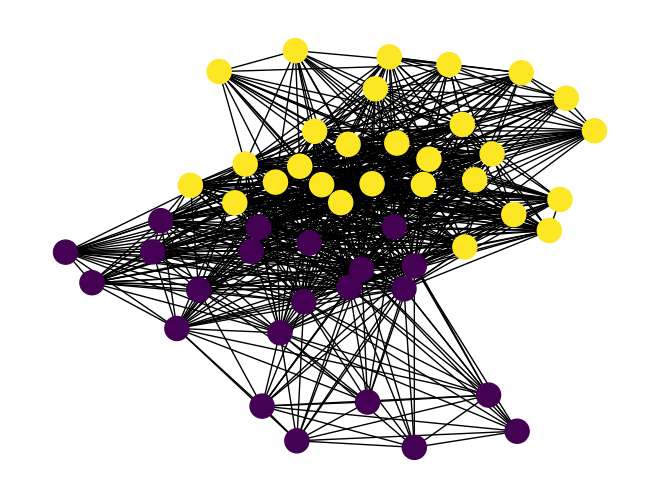

In [17]:
#for now we use a basic 2 clustering to demonstrate the concept
color_vec = list(partition.values())
nx.draw(WG,pos=nx.spring_layout(WG),node_color=color_vec)

In [19]:
import numpy as np
clusters_num = len(set(partition.values()))
clusters = [[] for _ in range(clusters_num)]


for i in partition.keys():
    clusters[partition[i]].append(i)

print(clusters)
    
    

[[2048141210, 2048141664, 6518254705, 3496259400, 6518282587, 6518718188, 172107400, 172106984, 172107221, 172476042, 194899356, 194899357, 194900836, 194900838, 206049819, 206049829, 206055847, 206055848, 206055872, 206055889, 206055891, 206055902], [9527820254, 172476067, 194900833, 194900835, 194902255, 194902256, 194902257, 206049826, 206055846, 206055854, 206055855, 206055860, 206055862, 206055865, 206055867, 206055868, 206055884, 206055885, 206055887, 206055893, 206055903, 206055904, 206055911, 9372258798, 9527820253, 9527820259, 172099678, 172476341]]


In [20]:
# Get the data and set working directory
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [16]:
import folium
map_osm = folium.Map(location=[(27.62164 + 27.61369)/2,(85.55298+ 85.54105)/2],zoom_start=16)
map_osm

In [21]:
color = ['red' , 'green' , 'black']
for i in partition:
    print(i)
    folium.Marker(building_data[i], icon=folium.Icon(color=color[partition[i]])).add_to(map_osm)

2048141210


IndexError: list index out of range

In [23]:
print(partition)

{2048141210: 0, 2048141664: 0, 6518254705: 0, 3496259400: 0, 6518282587: 0, 6518718188: 0, 172107400: 0, 9527820254: 1, 172106984: 0, 172107221: 0, 172476042: 0, 172476067: 1, 194899356: 0, 194899357: 0, 194900833: 1, 194900835: 1, 194900836: 0, 194900838: 0, 194902255: 1, 194902256: 1, 194902257: 1, 206049819: 0, 206049826: 1, 206049829: 0, 206055846: 1, 206055847: 0, 206055848: 0, 206055854: 1, 206055855: 1, 206055860: 1, 206055862: 1, 206055865: 1, 206055867: 1, 206055868: 1, 206055872: 0, 206055884: 1, 206055885: 1, 206055887: 1, 206055889: 0, 206055891: 0, 206055893: 1, 206055902: 0, 206055903: 1, 206055904: 1, 206055911: 1, 9372258798: 1, 9527820253: 1, 9527820259: 1, 172099678: 1, 172476341: 1}
